<a href="https://colab.research.google.com/github/adidror005/youtube-videos/blob/main/trump_elon_tsla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trump and Elon Interview
* Can we find out of they spoke about things that could impact TSLA investors?

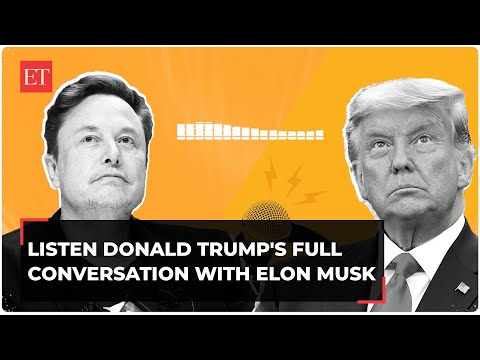

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('lfBQoWxQaEM')


### Steps
1. Get MP3 File from Youtube Video
  - *pyTubefix* to download video
  - *moviepy* to convert MP4 to MP3
3. *pydub*: Split MP3 File to 10 parts due to OpenAI's *Whisper* limit
4. *openai*: Convert speech to text with OpenAI's *Whisper*
5. *llama_index*: Use Llama Index to index nodes of the text so we can search over them.


### Installs

In [5]:
!pip install -q pytubefix -q pydub -q moviepy -q openai -q llama-index

**Part 1**. Get MP3 File from Youtube Video
  - Part 1a: Use *pyTube* to download video


In [6]:
from pytubefix import YouTube
yt = YouTube('https://www.youtube.com/watch?v=lfBQoWxQaEM&t=289s')
yt.streams.first().download()


'/content/Donald Trump-Elon Musk full conversation From assassination attempt to low IQ Biden and more.mp4'

  - Part 1b: Use *moviepy* to convert MP4 to MP3



In [ ]:
from moviepy.editor import VideoFileClip
video = VideoFileClip('/content/Donald Trump-Elon Musk full conversation From assassination attempt to low IQ Biden and more.mp4')
video.audio.write_audiofile("elon_trump.mp3")

MoviePy - Writing audio in elon_trump.mp3


chunk:  64%|██████▍   | 103100/159988 [02:05<00:59, 951.30it/s, now=None]

**Part 2**. Use *pydub* to split MP3 File to 10 parts due to OpenAI's Whisper limit
* Note I am not worrying about what I cut off at the end

In [ ]:
from pydub import AudioSegment
full_mp3 = AudioSegment.from_mp3("elon_trump.mp3")
full_text_length = len(full_mp3)
for i in range(10):
  partial_mp3 = full_mp3[i*full_text_length//10:(i+1)*full_text_length//10] #Missing some at end who cares...
  partial_mp3.export(f"partial_{i}.mp3", format="mp3")

**Part 3**. Use *openai* whisper on each mp3 chunk to convert speech to text


In [10]:
from openai import OpenAI
import os
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY']=userdata.get('OPENAI_API_KEY')
client = OpenAI()
transcriptions=[]
for i in range(10):
  audio_file= open(f"partial_{i}.mp3", "rb")
  transcription = client.audio.transcriptions.create(
    model="whisper-1",
    file=audio_file
  )
  transcriptions.append(transcription)

* Let's combine text

In [36]:
transcriptions[0].text

"Hello, everyone. My apologies for the late start. We unfortunately had a massive distributed denial of service attack against our servers and saturated all of our data lines, like basically hundreds of gigabits of data were saturated. We think we've overcome most of that, and so it's now time to proceed. But as this massive attack illustrates, there's a lot of opposition to people just hearing what President Trump has to say. But I'm honored to have this conversation. I want to emphasize it's a conversation, and it's really intended to just get a feel for what Donald Trump is just like in a conversation. It's hard to catch a vibe about someone if you just don't hear them talk in a normal way. When there's an adversarial interview, no one's themselves in an adversarial interview. This is really aimed at open-minded, independent voters who are just trying to make up their mind. You can understand what is it just like to have a conversation. I'm honored. Donald, great to speak. We had a 

In [11]:
full_text = "".join([t.text for t in transcriptions])

### Llama Index Part

In [ ]:
from llama_index.core import Settings
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.core import Document


* Select LLM and Embedding Model

In [17]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

Settings.llm = OpenAI(temperature=0, model="gpt-4")
Settings.embed_model = OpenAIEmbedding(model='text-embedding-3-large')

* Split large "document" into nodes


In [18]:
from llama_index.core import Document
from llama_index.core.node_parser import SentenceSplitter


documents = [Document(text=full_text)]

parser = SentenceSplitter(chunk_size=512,chunk_overlap=64)
nodes = parser.get_nodes_from_documents(documents)


In [37]:
len(nodes),len(documents)

(67, 1)

* Create VectorStore Index

In [38]:
from llama_index.core import VectorStoreIndex

vector_index = VectorStoreIndex(nodes)

* Create Query Engine from Index

In [21]:
query_engine = vector_index.as_query_engine(llm=OpenAI(temperature=0, model="gpt-4"))

### Query the query engine

In [39]:
response=query_engine.query("Can you summarize the most relevant parts of the conversation related to TSLA stock investors?")

In [40]:
print(response.response)

The conversation relevant to TSLA stock investors revolves around the company's commitment to sustainability and the belief that solar power will be a majority of US energy generation in the future. The speaker mentions that Tesla is working towards this goal by combining solar power with batteries to charge electric cars, providing a long-term sustainable solution. The speaker also emphasizes that Tesla's cars are designed to be attractive, perform well, and be environmentally friendly, suggesting that caring for the environment doesn't mean compromising on quality or performance.


In [41]:
response=query_engine.query(
"""
Can you summarize the most relevant parts of the conversation related to TSLA stock investors?
Can you please write it as bullet points in multiple lines
""")

In [42]:
print(response.response)

- The speaker acknowledges the quality of Tesla's products, stating that they are incredible.
- The speaker discusses the importance of reducing energy costs, including gasoline, which could impact the cost of running electric vehicles like those produced by Tesla.
- The speaker mentions the need for increased energy production to support technologies like AI, which Tesla is heavily invested in.
- The speaker criticizes the current administration's energy policies, suggesting a return to more traditional energy sources, which could potentially affect Tesla's position in the market.


In [43]:
response=query_engine.query(
"""
Can you summarize the main parts of this discussion?
Can you return it in a multi line format so i can print it nicely?
""")

In [44]:
print(response.response)


- The discussion began with an apology for a late start due to a massive distributed denial of service attack on the servers.
- The speaker expressed their intention to have a casual conversation with President Trump, aiming to provide insight into his personality beyond adversarial interviews.
- They mentioned a previous successful conversation with Trump and hoped to replicate it.
- The speaker congratulated Trump on breaking records with the number of people tuning in.
- They brought up an assassination attempt on Trump, praising his resilience and strength in the face of danger.
- Trump responded by discussing how the assassination attempt was thwarted due to a specific angle related to illegal immigration, which he found miraculous.
- He mentioned that he was about to discuss positive numbers related to illegal immigration before the assassination attempt.
- Trump also mentioned plans to return to Butler in October and praised the people there.
- The conversation ended with a ligh